In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
# from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller

import pmdarima as pm

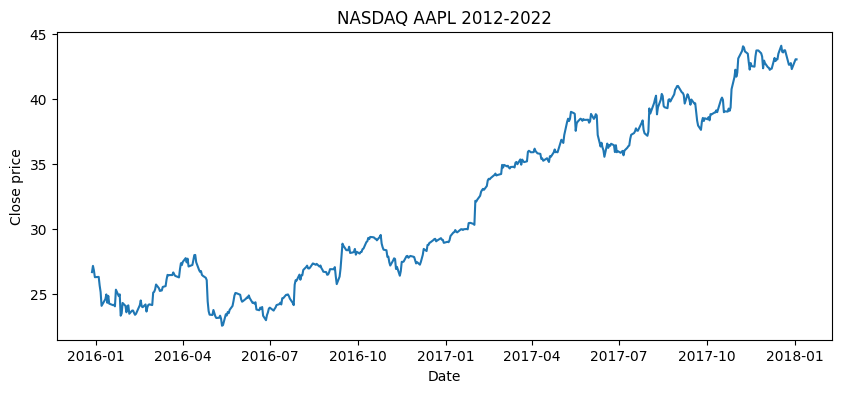

In [3]:
df = pd.read_csv("C:/Users/maelm/Documents/L2/PROJET S3/Apple/AAPL.csv")[7837:]

#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df.head(5)

df_bis = pd.read_csv("C:/Users/maelm/Documents/L2/PROJET S3/Apple/AAPL.csv")[8837: 9346]
df_bis['Date'] = pd.to_datetime(df_bis['Date'],infer_datetime_format=True)
df_bis = df_bis.set_index(['Date'])
# 2011 : 7500
# 3 janvier 2012 : 7837
# 2 janvier 2019 : 9597
# 2 janvier 2018 : 9346

plt.figure(figsize=(10,4))
plt.title("NASDAQ AAPL 2012-2022")
plt.xlabel('Date')
plt.ylabel('Close price')
plt.plot(df_bis['Close'])

plt.show()

In [ ]:
# moyenne glissante et seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_model_results = seasonal_decompose(df_bis['Close'], period=253)
plt.figure(figsize=(10,4))
rolmean1 = df_bis['Close'].rolling(10).mean()
rolmean2 = df_bis['Close'].rolling(50).mean()
rolmean3 = df_bis['Close'].rolling(80).mean()
rolmean4 = df_bis['Close'].rolling(120).mean()
#rolstd = df_bis['Close'].rolling(30).std()
#Plot rolling statistics:
plt.plot(df_bis['Close'], color='blue',label='Original', linewidth=1)
# plt.plot(rolmean1, color='red', label='RM10', linewidth=1)
plt.plot(rolmean2, color='red', label='RM50', linewidth=1)
"""plt.plot(rolmean3, color='green', label='RM80', linewidth=1)
plt.plot(rolmean4, color='brown', label='RM120', linewidth=1)
plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth=1)"""
plt.legend(loc='best')
plt.plot(seasonal_model_results.trend, color="green")
plt.title('Moyenne Glissante TESLA_close')
plt.show(block=False)


# plt.plot(seasonal_model_results.observed, color="yellow")


fig = plt.figure()  
fig = seasonal_model_results.plot()  
fig.set_size_inches(10, 4)

In [22]:


def combine_seasonal_cols(input_df, seasonal_model_results):

    """Adds inplace new seasonal cols to df given seasonal results

    Args:
        input_df (pandas dataframe)
        seasonal_model_results (statsmodels DecomposeResult object)
    """
    # Add results to original df
    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend

sd = seasonal_decompose(df_bis['Close'], period=12)
combine_seasonal_cols(df_bis['Close'], sd) # custom helper function

C:\Users\maelm\AppData\Local\Temp\ipykernel_47932\1414658490.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['observed'] = seasonal_model_results.observed


In [5]:
# prédiction 

data = pd.read_csv("C:/Users/maelm/Documents/L2/PROJET S3/Apple/AAPL.csv")

#string to date format
data['Date'] = pd.to_datetime(data['Date'],infer_datetime_format=True)[9597:]
data = data.set_index(['Date'])

data_bis = pd.read_csv("C:/Users/maelm/Documents/L2/PROJET S3/Apple/AAPL.csv")[9500:9800]
data_bis['Date'] = pd.to_datetime(data_bis['Date'],infer_datetime_format=True)
data_bis = data_bis.set_index(['Date'])

In [4]:
# rolmean10 = df_bis['Close'].rolling(10).mean()[10:]
ARIMA_model = pm.auto_arima(df_bis['Close'], start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, 
                         m=3, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=False, #set to seasonal
                         d=None, 
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

#ARIMA_model.plot_diagnostics(figsize=(15,12))

# plt.show()

C:\Users\maelm\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (3) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


509    43.089689
510    43.121879
511    43.154069
512    43.186259
513    43.218449
         ...    
604    46.147731
605    46.179920
606    46.212110
607    46.244300
608    46.276490
Length: 100, dtype: float64
2018-01-03    43.089689
2018-01-04    43.121879
2018-01-05    43.154069
2018-01-08    43.186259
2018-01-09    43.218449
                ...    
2018-05-16    46.147731
2018-05-17    46.179920
2018-05-18    46.212110
2018-05-21    46.244300
2018-05-22    46.276490
Freq: B, Length: 100, dtype: float64


C:\Users\maelm\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


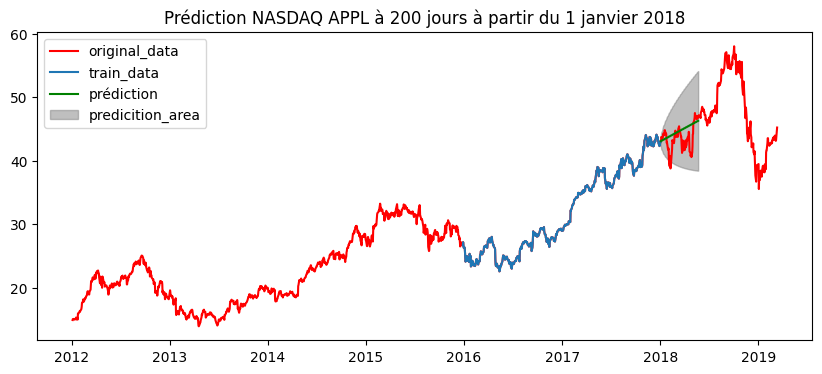

In [7]:
def forecast(ARIMA_model, periods=100):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_bis.index[-1] + pd.DateOffset(day=0), periods = n_periods, freq='B')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted.array, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(df['Close'][:"2019-03-12"], color='red', label ="original_data")
    plt.plot(df_bis["Close"], color='#1f76b4', label="train_data")
    plt.plot(fitted_series, color='green', label="prédiction")
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series,
                    label="predicition_area", 
                    color='grey', alpha=.50)

    plt.title("Prédiction NASDAQ APPL à 200 jours à partir du 1 janvier 2018")
    plt.legend()
    plt.show()

forecast(ARIMA_model)